In [34]:
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
from optuna.trial import TrialState
import joblib

import statistics
from sklearn.model_selection import KFold
import time
from utils import calculate_metric

from pytorch_tabular.models import GANDALFConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
    ExperimentConfig
)
from pytorch_tabular import TabularModel
import warnings
import matplotlib.pyplot as plt

In [3]:
# set random seeds
np.random.seed(0)
torch.manual_seed(0)

In [30]:
INPUT_FILE = "../data/data_removing_na.xlsx"
MODEL_PATH = '../output/GANDALF_bagging'
BATCH_SIZE = 32

PROJECT_NAME = "run/GANDALF_bagging"
TRAINING_OUTPUT_FILE = '../output/train_predictions.xlsx'
TEST_OUTPUT_FILE = '../output/test_predictions.xlsx'
SHEET_NAME = "GANDALF_bagging"
OUTPUT_FILE = MODEL_PATH + '/GANDALF_bagging.pkl'

DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [5]:
DEVICE

device(type='cpu')

In [6]:
df = pd.read_excel(INPUT_FILE)

In [7]:
df.head()

,rr1_30,currency,seniorioty_adj,coupon rate,domicile_country,exchange_country,Industry_sector,Industry_group,Industry_subgroup,event_type,...,PD_55_pd,PD_56_pd,PD_57_pd,PD_58_pd,PD_59_pd,PD_60_pd,DTD,NI_Over_TA,Size,defaulted_in_last_6_months
0,0.259908,USD,Senior Subordinated Unsecured,9.000,United States,United States,Consumer Discretionary,Retail & Whsle - Discretionary,E-Commerce Discretionary,Bankruptcy Filing,...,0.396731,0.397453,0.398148,0.398819,0.399467,0.400092,-0.732815,-0.007137,-0.852484,False
1,0.032729,USD,Senior Subordinated Unsecured,5.750,United States,United States,Health Care,Health Care,Health Care Facilities & Svcs,Default Corp Action,...,0.957454,0.957467,0.957480,0.957492,0.957503,0.957514,-1.666262,-0.000286,-1.186347,False
2,0.972400,USD,Unsecured,5.675,South Korea,South Korea,Consumer Discretionary,Retail & Whsle - Discretionary,Wholesale - Discretionary,Default Corp Action,...,0.568169,0.568693,0.569197,0.569682,0.570150,0.570600,-1.853366,0.000191,1.053677,False
3,1.047416,CHF,Unsecured,0.125,South Korea,South Korea,Consumer Discretionary,Retail & Whsle - Discretionary,Wholesale - Discretionary,Default Corp Action,...,0.568169,0.568693,0.569197,0.569682,0.570150,0.570600,-1.853366,0.000191,1.053677,False
4,0.848872,JPY,Unsecured,1.750,Japan,Japan,Industrials,Industrial Products,Electrical Equipment,Bankruptcy Filing,...,0.130285,0.130688,0.131081,0.131465,0.131840,0.132206,-0.768857,-0.028058,-1.946507,False


In [8]:
df.shape

(1725, 165)

In [9]:
feature_list = df.columns
feature_list = feature_list.drop('rr1_30')

In [10]:
feature_list

Index(['currency', 'seniorioty_adj', 'coupon rate', 'domicile_country',
       'exchange_country', 'Industry_sector', 'Industry_group',
       'Industry_subgroup', 'event_type', 'event_type_subcategory_sum',
       ...
       'PD_55_pd', 'PD_56_pd', 'PD_57_pd', 'PD_58_pd', 'PD_59_pd', 'PD_60_pd',
       'DTD', 'NI_Over_TA', 'Size', 'defaulted_in_last_6_months'],
      dtype='object', length=164)

In [11]:
category_features = list(df.select_dtypes(include=['object', 'bool']).columns)
non_category_features = [i for i in feature_list if i not in category_features]

In [12]:
print(len(non_category_features))
print(len(category_features))

153
11


In [13]:
category_features

['currency',
 'seniorioty_adj',
 'domicile_country',
 'exchange_country',
 'Industry_sector',
 'Industry_group',
 'Industry_subgroup',
 'event_type',
 'event_type_subcategory_sum',
 'defaulted_in_last_5_years',
 'defaulted_in_last_6_months']

In [14]:
# split data into training and test set
test_size = 0.25
train, test = train_test_split(df, test_size=test_size, random_state=42)

In [15]:
train.head()

,rr1_30,currency,seniorioty_adj,coupon rate,domicile_country,exchange_country,Industry_sector,Industry_group,Industry_subgroup,event_type,...,PD_55_pd,PD_56_pd,PD_57_pd,PD_58_pd,PD_59_pd,PD_60_pd,DTD,NI_Over_TA,Size,defaulted_in_last_6_months
755,0.082481,USD,Senior Unsecured,7.500,United States,United States,Energy,Oil & Gas,Oil & Gas Producers,Default Corp Action,...,0.691011,0.691382,0.691738,0.692080,0.692408,0.692725,-1.084433,-0.052027,-2.074964,False
588,0.378845,USD,Unsecured,6.000,Indonesia,Indonesia,Materials,Materials,Metals & Mining,Default Corp Action,...,0.183801,0.184996,0.186167,0.187313,0.188437,0.189539,-0.540409,0.017209,0.864692,False
585,0.836149,USD,Senior Secured,11.000,United States,United States,Materials,Materials,Metals & Mining,Default Corp Action,...,0.278774,0.280216,0.281615,0.282972,0.284290,0.285571,0.754647,-0.010395,-0.342209,False
1329,0.987208,USD,Senior Secured,9.125,United States,United States,Energy,Oil & Gas,Oil & Gas Services & Equip,Default Corp Action,...,0.190375,0.191471,0.192544,0.193594,0.194622,0.195628,-0.242080,-0.022618,-2.808528,False
973,1.021458,USD,Senior Secured,9.250,United States,United States,Energy,Oil & Gas,Oil & Gas Producers,Default Corp Action,...,0.149501,0.150930,0.152327,0.153692,0.155027,0.156332,1.138686,0.000033,-0.085154,False


TUNING PARAMETERS

In [16]:
EPOCHS = 50

target_col = 'rr1_30'

data_config = DataConfig(
    target=[
        target_col
    ],  # target should always be a list
    continuous_cols=non_category_features,
    categorical_cols=category_features,
)

optimizer_config = OptimizerConfig()
experiment_config = ExperimentConfig(project_name=PROJECT_NAME,exp_watch="all",log_target="tensorboard")

trainer_config = TrainerConfig(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS,
    early_stopping=None
)


In [20]:
def objective(trial):
    #Number of layers in the feature abstraction
    gflu_stages = trial.suggest_int("gflu_stages", 1, 10, log=True)
    
    #initial percentage of features to be selected in each GFLU stage.
    gflu_feature_init_sparsity = trial.suggest_float("gflu_feature_init_sparsity", 0.1, 1, log=True)
    gflu_dropout = trial.suggest_float("gflu_dropout", 0, 0.5)

    # Generate the optimizers.
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    
    model_config = GANDALFConfig(
            task="regression",
            gflu_stages=gflu_stages,    #Number of layers in the feature abstraction
            gflu_feature_init_sparsity=gflu_feature_init_sparsity, #initial percentage of features to be selected in each GFLU stage.
            gflu_dropout=gflu_dropout,
            learning_rate=lr,
        )
    # Initialize the model
    tabular_model = TabularModel(
            data_config=data_config,
            model_config=model_config,
            optimizer_config=optimizer_config,
            trainer_config=trainer_config,
            experiment_config=experiment_config,
            verbose=True
        )

    # training with 5-fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []

    for index, (train_idx, val_idx) in enumerate(kf.split(train)):
        # Create training and validation datasets for the current fold
        train_fold, val_fold = train.iloc[train_idx], train.iloc[val_idx]
            
        # Train the model
        bagged_pred_df = tabular_model.bagging_predict(
            cv=5, train=train_fold, test=val_fold, aggregate="mean"
        )
        mae, mape, rmse, rsqr = calculate_metric(bagged_pred_df.to_numpy().squeeze(), val_fold[target_col].to_numpy())
        mse_scores.append(rmse)

        trial.report(rmse, index)

    # Return the average validation loss across all folds
    return np.mean(mse_scores)

In [21]:
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2025-04-07 09:53:43,886] A new study created in memory with name: no-name-1e4fc111-27de-41a4-a67f-8c8c4aa523d3


2025-04-07 09:53:43,924 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 1/5

2025-04-07 09:53:43,926 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 09:53:43,930 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 09:53:43,972 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 09:53:44,050 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 09:53:44,065 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 09:53:44,077 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 09:56:00,030 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 09:56:00,032 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 09:56:00,174 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 1/5 prediction done

2025-04-07 09:56:00,191 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 2/5

2025-04-07 09:56:00,195 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 09:56:00,202 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 09:56:00,294 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 09:56:00,448 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 09:56:00,468 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 09:56:00,529 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    239 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 09:58:13,412 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 09:58:13,413 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 09:58:13,491 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 2/5 prediction done

2025-04-07 09:58:13,514 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 3/5

2025-04-07 09:58:13,518 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 09:58:13,527 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 09:58:13,595 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 09:58:13,743 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 09:58:13,764 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 09:58:13,836 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    239 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:00:13,816 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:00:13,819 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:00:13,954 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 3/5 prediction done

2025-04-07 10:00:13,973 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 4/5

2025-04-07 10:00:13,978 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:00:13,985 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:00:14,064 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:00:14,201 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:00:14,222 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:00:14,296 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    239 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:02:45,489 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:02:45,491 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:02:45,590 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 4/5 prediction done

2025-04-07 10:02:45,610 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 5/5

2025-04-07 10:02:45,616 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:02:45,629 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:02:45,699 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:02:45,931 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:02:45,953 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:02:46,056 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    239 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:04:49,013 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:04:49,015 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:04:49,205 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 5/5 prediction done

2025-04-07 10:04:49,229 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 1/5

2025-04-07 10:04:49,232 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:04:49,245 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:04:49,320 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:04:49,459 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:04:49,717 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:04:49,784 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:06:53,517 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:06:53,519 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:06:53,631 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 1/5 prediction done

2025-04-07 10:06:53,650 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 2/5

2025-04-07 10:06:53,652 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:06:53,660 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:06:53,738 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:06:53,881 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:06:53,902 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:06:53,977 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    241 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:08:55,751 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:08:55,753 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:08:56,028 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 2/5 prediction done

2025-04-07 10:08:56,048 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 3/5

2025-04-07 10:08:56,052 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:08:56,067 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:08:56,139 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:08:56,283 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:08:56,303 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:08:56,374 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    241 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:11:21,876 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:11:21,879 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:11:22,122 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 3/5 prediction done

2025-04-07 10:11:22,158 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 4/5

2025-04-07 10:11:22,166 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:11:22,176 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:11:22,306 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:11:22,460 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:11:22,483 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:11:22,582 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:14:15,690 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:14:15,692 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:14:16,074 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 4/5 prediction done

2025-04-07 10:14:16,096 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 5/5

2025-04-07 10:14:16,102 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:14:16,112 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:14:16,241 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:14:16,408 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:14:16,431 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:14:16,511 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.7 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:17:13,524 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:17:13,526 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:17:13,648 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 5/5 prediction done

2025-04-07 10:17:13,675 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 1/5

2025-04-07 10:17:13,679 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:17:13,698 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:17:13,999 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:17:14,170 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:17:14,190 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:17:14,267 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:19:19,703 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:19:19,705 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:19:19,796 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 1/5 prediction done

2025-04-07 10:19:19,815 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 2/5

2025-04-07 10:19:19,818 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:19:19,825 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:19:19,893 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:19:20,039 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:19:20,060 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:19:20,132 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:21:24,872 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:21:24,874 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:21:25,024 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 2/5 prediction done

2025-04-07 10:21:25,046 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 3/5

2025-04-07 10:21:25,051 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:21:25,062 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:21:25,168 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:21:25,314 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:21:25,335 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:21:25,413 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    242 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:23:56,905 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:23:56,907 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:23:57,001 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 3/5 prediction done

2025-04-07 10:23:57,020 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 4/5

2025-04-07 10:23:57,024 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:23:57,032 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:23:57,105 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:23:57,245 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:23:57,268 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:23:57,341 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    242 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:25:46,697 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:25:46,699 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:25:46,800 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 4/5 prediction done

2025-04-07 10:25:46,818 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 5/5

2025-04-07 10:25:46,821 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:25:46,828 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:25:46,899 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:25:47,034 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:25:47,058 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:25:47,131 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    242 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:27:35,990 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:27:35,992 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:27:36,078 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 5/5 prediction done

2025-04-07 10:27:36,100 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 1/5

2025-04-07 10:27:36,103 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:27:36,112 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:27:36,188 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:27:36,323 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:27:36,343 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:27:36,420 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:29:24,927 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:29:24,928 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:29:25,013 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 1/5 prediction done

2025-04-07 10:29:25,032 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 2/5

2025-04-07 10:29:25,035 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:29:25,043 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:29:25,113 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:29:25,258 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:29:25,282 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:29:25,354 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    239 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:31:19,004 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:31:19,005 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:31:19,099 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 2/5 prediction done

2025-04-07 10:31:19,119 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 3/5

2025-04-07 10:31:19,122 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:31:19,129 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:31:19,196 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:31:19,336 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:31:19,357 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:31:19,427 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    241 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:33:07,111 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:33:07,113 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:33:07,217 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 3/5 prediction done

2025-04-07 10:33:07,239 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 4/5

2025-04-07 10:33:07,242 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:33:07,257 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:33:07,471 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:33:07,615 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:33:07,637 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:33:07,722 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:35:01,408 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:35:01,410 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:35:01,555 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 4/5 prediction done

2025-04-07 10:35:01,573 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 5/5

2025-04-07 10:35:01,577 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:35:01,585 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:35:01,666 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:35:01,799 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:35:01,821 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:35:01,890 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    242 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:36:51,061 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:36:51,062 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:36:51,174 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 5/5 prediction done

2025-04-07 10:36:51,200 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 1/5

2025-04-07 10:36:51,203 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:36:51,214 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:36:51,289 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:36:51,430 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:36:51,458 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:36:51,575 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:38:44,995 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:38:44,997 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:38:45,114 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 1/5 prediction done

2025-04-07 10:38:45,131 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 2/5

2025-04-07 10:38:45,134 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:38:45,144 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:38:45,226 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:38:45,372 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:38:45,394 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:38:45,464 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:40:39,357 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:40:39,359 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:40:39,450 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 2/5 prediction done

2025-04-07 10:40:39,470 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 3/5

2025-04-07 10:40:39,473 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:40:39,481 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:40:39,562 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:40:39,708 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:40:39,729 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:40:39,810 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    241 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:42:43,933 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:42:43,934 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:42:44,066 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 3/5 prediction done

2025-04-07 10:42:44,084 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 4/5

2025-04-07 10:42:44,087 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:42:44,096 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:42:44,170 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:42:44,313 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:42:44,336 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:42:44,409 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    242 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:44:42,892 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:44:42,894 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:44:42,976 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 4/5 prediction done

2025-04-07 10:44:42,995 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 5/5

2025-04-07 10:44:42,998 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 10:44:43,005 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 10:44:43,105 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 10:44:43,263 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 10:44:43,285 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 10:44:43,360 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


2025-04-07 10:46:57,544 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 10:46:57,546 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 10:46:57,667 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 5/5 prediction done

[I 2025-04-07 10:46:57,691] Trial 0 finished with value: 0.33944122524476467 and parameters: {'gflu_stages': 7, 'gflu_feature_init_sparsity': 0.3229093069406744, 'gflu_dropout': 0.08586469259275054, 'learning_rate': 0.017914503521860834}. Best is trial 0 with value: 0.33944122524476467.


Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.33944122524476467
  Params: 
    gflu_stages: 7
    gflu_feature_init_sparsity: 0.3229093069406744
    gflu_dropout: 0.08586469259275054
    learning_rate: 0.017914503521860834


In [22]:
trial.params

{'gflu_stages': 7,
 'gflu_feature_init_sparsity': 0.3229093069406744,
 'gflu_dropout': 0.08586469259275054,
 'learning_rate': 0.017914503521860834}

RUNNING THE MODEL

In [17]:
# empty cache first
torch.cuda.empty_cache()

In [23]:
EPOCHS = 100

target_col = 'rr1_30'

data_config = DataConfig(
    target=[
        target_col
    ],  # target should always be a list
    continuous_cols=non_category_features,
    categorical_cols=category_features,
)

optimizer_config = OptimizerConfig()
experiment_config = ExperimentConfig(project_name=PROJECT_NAME,exp_watch="all",log_target="tensorboard")

trainer_config = TrainerConfig(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS,
    early_stopping=None
)

# best_params = {'gflu_stages': 9,
#  'gflu_feature_init_sparsity': 0.1950409583306746,
#  'gflu_dropout': 0.030707294595931856,
#  'learning_rate': 0.015269936277354889}

best_params = trial.params


model_config = GANDALFConfig(
    task="regression",
    metrics=["mean_absolute_error", "mean_absolute_percentage_error", "mean_squared_error", "r2_score"],
    **best_params
)


In [24]:
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    experiment_config=experiment_config,
    verbose=True
)

In [25]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bagged_pred_df = tabular_model.bagging_predict(
        cv=5, train=train, test=test, aggregate="mean"
    )

2025-04-07 11:22:38,069 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 1/5

2025-04-07 11:22:38,074 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 11:22:38,081 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

2025-04-07 11:22:38,127 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 11:22:38,202 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 11:22:38,221 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 11:22:38,263 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.5 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.7 K │ train │
│ 2 │ _head            │ Sequential       │    244 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 11:27:55,324 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 11:27:55,325 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

2025-04-07 11:27:55,480 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 1/5 prediction done

2025-04-07 11:27:55,498 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 2/5

2025-04-07 11:27:55,502 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 11:27:55,510 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

2025-04-07 11:27:55,577 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 11:27:55,713 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 11:27:55,738 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 11:27:55,817 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    241 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 11:34:15,636 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 11:34:15,640 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

2025-04-07 11:34:15,856 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 2/5 prediction done

2025-04-07 11:34:15,876 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 3/5

2025-04-07 11:34:15,881 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 11:34:15,891 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

2025-04-07 11:34:15,967 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 11:34:16,098 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 11:34:16,126 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 11:34:16,205 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 11:39:16,021 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 11:39:16,023 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

2025-04-07 11:39:16,405 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 3/5 prediction done

2025-04-07 11:39:16,416 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 4/5

2025-04-07 11:39:16,420 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 11:39:16,425 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

2025-04-07 11:39:16,465 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 11:39:16,537 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 11:39:16,553 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 11:39:16,615 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 11:43:28,580 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 11:43:28,581 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

2025-04-07 11:43:28,689 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 4/5 prediction done

2025-04-07 11:43:28,701 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 5/5

2025-04-07 11:43:28,703 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 11:43:28,710 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

2025-04-07 11:43:28,761 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 11:43:28,831 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 11:43:28,846 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 11:43:28,906 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.7 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 11:47:24,258 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 11:47:24,259 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

2025-04-07 11:47:24,350 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 5/5 prediction done

In [26]:
 # save metrics
mae, mape, rmse, rsqr = calculate_metric(bagged_pred_df.to_numpy().squeeze(), test[target_col].to_numpy())
print(f"Test average mean absolute error: {mae}")
print(f"Test average mean absolute percentage error: {mape}")
print(f"Test average root mean squared error: {rmse}")
print(f"Test average R2: {rsqr}")

Test average mean absolute error: 0.17270184262468233
Test average mean absolute percentage error: 324.85607810783057
Test average root mean squared error: 0.2321947271898611
Test average R2: 0.5293127995331639


In [31]:
# save train predictions
# with pd.ExcelWriter(TRAINING_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
#     # Write the new DataFrame to a new sheet
#     train_predictions.to_excel(writer, sheet_name=SHEET_NAME, index=False)
    
# save test predictions
with pd.ExcelWriter(TEST_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    bagged_pred_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)

# Save the best model
joblib.dump(tabular_model, OUTPUT_FILE)

['../output/GANDALF_bagging/GANDALF_bagging.pkl']

FEATURE IMPORTANCE

In [32]:
native_ft_importance = tabular_model.feature_importance().sort_values("importance", ascending=False)
native_ft_importance

,Features,importance
86,PD_1_median_exch,1.999998e+00
121,PD_21_pd,1.999997e+00
85,dtd_median_exch,1.480471e+00
79,Long-term_ratio,5.195277e-01
6,Industry_subgroup,3.846152e-02
...,...,...
25,US Generic Govt 5 Year Yield,3.085345e-08
88,PD_12_median_exch,3.079759e-08
127,PD_27_pd,3.023301e-08
35,PD_1_domicile_subsec,3.011441e-08


<Figure size 1400x600 with 0 Axes>

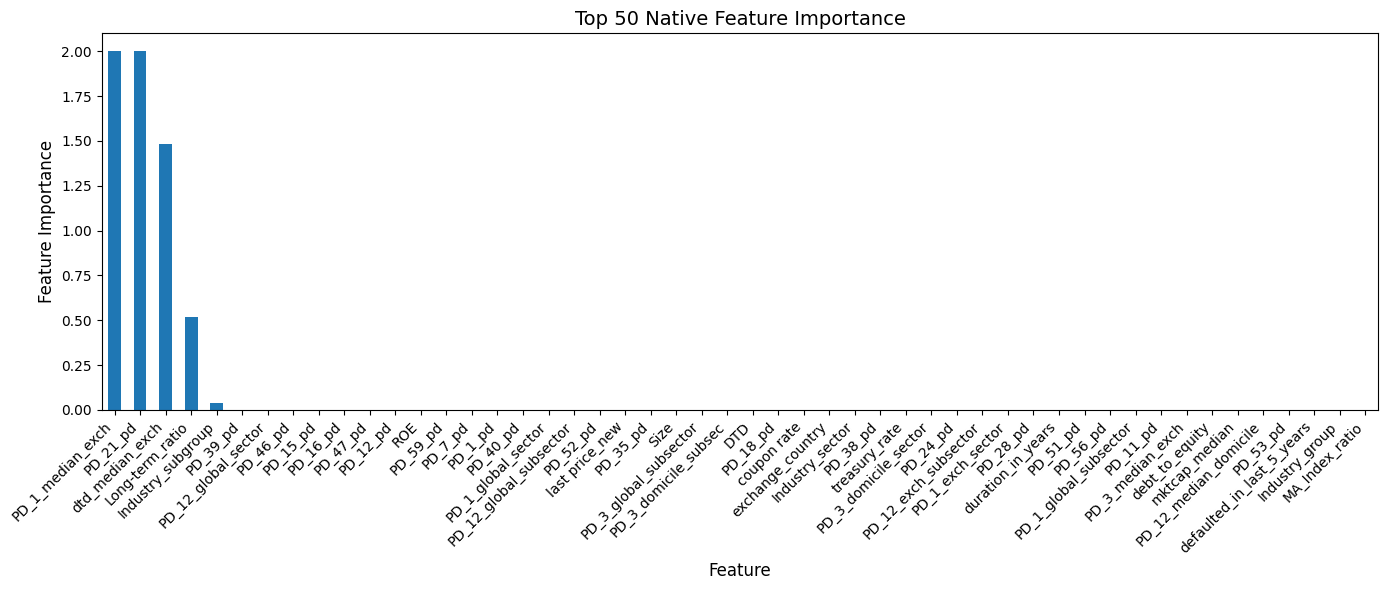

In [35]:
# Select the top 50 features
top_native_features = native_ft_importance.head(50)

# Set a larger figure size
plt.figure(figsize=(14, 6))

# Create the bar plot for top 50 features
top_native_features.plot(
    kind="bar", x="Features", y="importance", legend=False, figsize=(14, 6)
)

# Add title and labels
plt.title("Top 50 Native Feature Importance", fontsize=14)
plt.ylabel("Feature Importance", fontsize=12)
plt.xlabel("Feature", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)

# Adjust layout to prevent label overlap
plt.tight_layout()

plt.savefig(f"{MODEL_PATH}/native_feature_importance.png")

# Show the plot
plt.show()

SHAP on training

In [38]:
# Explain a single instance using the GradientShap method and baseline as 10000 samples from the training data
kernelSHAP = tabular_model.explain(train, method="KernelShap", baselines="b|1000")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/tabular_model.py:2020: UserWarning: KernelShap is computationally expensive and will take some time. For faster results, try usingsome other methods like GradientShap, IntegratedGradients etc.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Libr

In [39]:
feature_importance = kernelSHAP.abs().median().sort_values(ascending=False)

In [40]:
feature_importance

Industry_subgroup                0.014694
coupon rate                      0.007859
domicile_country                 0.007547
Industry_group                   0.007073
event_type_subcategory_sum       0.005407
                                   ...   
PD_12_domicile_sector            0.001047
PD_49_pd                         0.001044
PD_15_pd                         0.001034
PD_3_pd                          0.001033
shares_out_outstanding_shares    0.000998
Length: 164, dtype: float32

In [41]:
feature_importance_df = feature_importance.reset_index()
feature_importance_df.columns = ["Feature", "Importance"]

<Figure size 1400x600 with 0 Axes>

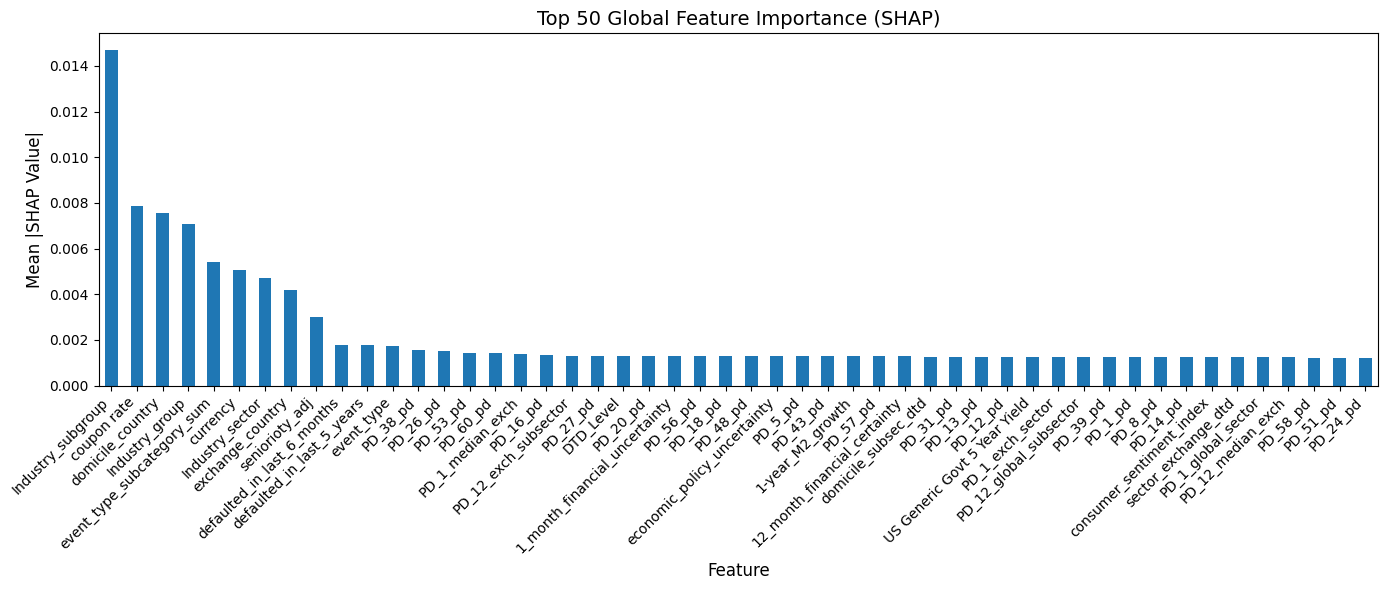

In [ ]:
# Select the top 50 features
top_features = feature_importance_df.head(50)

# Set a larger figure size
plt.figure(figsize=(14, 6))

# Create the bar plot for top 50 features
top_features.plot(
    kind="bar", x="Feature", y="Importance", legend=False, figsize=(14, 6)
)

# Add title and labels
plt.title("Top 50 Global Feature Importance (SHAP)", fontsize=14)
plt.ylabel("Mean |SHAP Value|", fontsize=12)
plt.xlabel("Feature", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)

# Adjust layout to prevent label overlap
plt.tight_layout()

# save the fig
plt.savefig(f"{MODEL_PATH}/training_shap.png")

# Show the plot
plt.show()

5 fold CV

In [44]:
# Define cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
EPOCHS = 100
val_mae = []
val_mape = []
val_rmse = []
val_rsqr = []

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    experiment_config=experiment_config,
    verbose=True
)

trainer_config = TrainerConfig(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS,
    early_stopping=None
)

model = None
datamodule = None

for index, (train_idx, val_idx) in enumerate(kf.split(df)):
        # Create training and validation datasets for the current fold
        train_fold, val_fold = df.iloc[train_idx], df.iloc[val_idx]
            
        # Train the model
        bagged_pred_df = tabular_model.bagging_predict(
            cv=5, train=train_fold, test=val_fold, aggregate="mean"
        )

        # Validation of the model.
        mae, mape, rmse, rsqr = calculate_metric(bagged_pred_df.to_numpy().squeeze(), val_fold[target_col].to_numpy())
        val_mae.append(mae)
        val_mape.append(mape)
        val_rmse.append(rmse)
        val_rsqr.append(rsqr)

2025-04-07 13:58:18,301 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 1/5

2025-04-07 13:58:18,303 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 13:58:18,309 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 13:58:18,365 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 13:58:18,443 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 13:58:18,460 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 13:58:18,518 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 14:03:59,057 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 14:03:59,061 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 14:03:59,261 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 1/5 prediction done

2025-04-07 14:03:59,282 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 2/5

2025-04-07 14:03:59,292 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 14:03:59,303 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 14:03:59,390 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 14:03:59,515 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 14:03:59,545 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 14:03:59,617 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    241 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 14:10:01,981 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 14:10:01,983 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 14:10:02,173 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 2/5 prediction done

2025-04-07 14:10:02,203 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 3/5

2025-04-07 14:10:02,268 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 14:10:02,294 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 14:10:02,420 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 14:10:02,550 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 14:10:02,578 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 14:10:02,661 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    241 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 14:15:48,831 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 14:15:48,833 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 14:15:49,004 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 3/5 prediction done

2025-04-07 14:15:49,023 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 4/5

2025-04-07 14:15:49,027 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 14:15:49,035 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 14:15:49,131 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 14:15:49,287 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 14:15:49,317 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 14:15:49,351 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.5 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.7 K │ train │
│ 2 │ _head            │ Sequential       │    244 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 14:22:08,226 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 14:22:08,232 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 14:22:08,651 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 4/5 prediction done

2025-04-07 14:22:08,675 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 5/5

2025-04-07 14:22:08,680 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 14:22:08,690 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 14:22:08,798 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 14:22:08,991 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 14:22:09,104 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 14:22:09,240 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.5 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.7 K │ train │
│ 2 │ _head            │ Sequential       │    245 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 14:28:14,110 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 14:28:14,112 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 14:28:14,320 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 5/5 prediction done

2025-04-07 14:28:14,395 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 1/5

2025-04-07 14:28:14,401 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 14:28:14,411 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 14:28:14,502 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 14:28:14,652 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 14:28:14,686 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 14:28:14,758 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 14:34:06,505 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 14:34:06,507 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 14:34:06,657 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 1/5 prediction done

2025-04-07 14:34:06,674 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 2/5

2025-04-07 14:34:06,678 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 14:34:06,685 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 14:34:06,784 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 14:34:06,928 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 14:34:06,955 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 14:34:07,031 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 14:40:00,084 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 14:40:00,086 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 14:40:00,394 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 2/5 prediction done

2025-04-07 14:40:00,511 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 3/5

2025-04-07 14:40:00,543 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 14:40:00,551 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 14:40:00,646 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 14:40:00,781 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 14:40:00,810 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 14:40:00,932 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    242 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 14:45:23,168 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 14:45:23,169 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 14:45:23,328 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 3/5 prediction done

2025-04-07 14:45:23,345 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 4/5

2025-04-07 14:45:23,348 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 14:45:23,356 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 14:45:23,426 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 14:45:23,558 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 14:45:23,585 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 14:45:23,663 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 14:53:39,863 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 14:53:39,865 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 14:53:40,042 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 4/5 prediction done

2025-04-07 14:53:40,061 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 5/5

2025-04-07 14:53:40,066 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 14:53:40,076 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 14:53:40,180 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 14:53:40,320 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 14:53:40,347 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 14:53:40,418 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.5 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.7 K │ train │
│ 2 │ _head            │ Sequential       │    245 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 14:59:13,249 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 14:59:13,252 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 14:59:13,493 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 5/5 prediction done

2025-04-07 14:59:13,523 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 1/5

2025-04-07 14:59:13,527 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 14:59:13,541 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 14:59:13,650 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 14:59:13,794 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 14:59:13,818 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 14:59:13,895 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 15:06:43,356 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 15:06:43,358 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 15:06:43,554 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 1/5 prediction done

2025-04-07 15:06:43,582 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 2/5

2025-04-07 15:06:43,592 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 15:06:43,626 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 15:06:43,741 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 15:06:43,878 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 15:06:43,912 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 15:06:43,951 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 15:12:48,480 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 15:12:48,482 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 15:12:48,654 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 2/5 prediction done

2025-04-07 15:12:48,673 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 3/5

2025-04-07 15:12:48,676 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 15:12:48,686 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 15:12:48,778 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 15:12:48,914 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 15:12:48,946 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 15:12:48,996 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    241 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 15:19:14,938 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 15:19:14,940 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 15:19:15,111 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 3/5 prediction done

2025-04-07 15:19:15,135 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 4/5

2025-04-07 15:19:15,145 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 15:19:15,159 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 15:19:15,294 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 15:19:15,422 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 15:19:15,444 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 15:19:15,514 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.5 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.7 K │ train │
│ 2 │ _head            │ Sequential       │    244 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 15:26:33,567 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 15:26:33,576 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 15:26:33,903 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 4/5 prediction done

2025-04-07 15:26:33,932 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 5/5

2025-04-07 15:26:33,940 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 15:26:33,954 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 15:26:34,067 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 15:26:34,328 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 15:26:34,388 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 15:26:34,557 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 15:34:57,167 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 15:34:57,190 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 15:34:59,020 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 5/5 prediction done

2025-04-07 15:34:59,166 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 1/5

2025-04-07 15:34:59,192 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 15:34:59,292 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 15:34:59,551 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 15:35:00,127 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 15:35:00,318 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 15:35:00,600 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    239 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 15:55:05,617 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 15:55:05,620 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 15:55:06,084 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 1/5 prediction done

2025-04-07 15:55:06,109 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 2/5

2025-04-07 15:55:06,115 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 15:55:06,127 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 15:55:06,264 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 15:55:06,430 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 15:55:06,472 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 15:55:06,591 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    239 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 16:02:27,928 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 16:02:27,930 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 16:02:28,058 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 2/5 prediction done

2025-04-07 16:02:28,078 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 3/5

2025-04-07 16:02:28,082 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 16:02:28,091 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 16:02:28,167 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 16:02:28,308 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 16:02:28,340 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 16:02:28,411 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    242 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 16:11:25,379 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 16:11:25,387 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 16:11:25,826 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 3/5 prediction done

2025-04-07 16:11:25,927 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 4/5

2025-04-07 16:11:25,932 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 16:11:25,954 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 16:11:26,061 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 16:11:26,432 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 16:11:26,489 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 16:11:26,593 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 16:24:31,738 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 16:24:31,739 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 16:24:31,813 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 4/5 prediction done

2025-04-07 16:24:31,825 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 5/5

2025-04-07 16:24:31,828 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 16:24:31,834 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 16:24:31,880 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 16:24:31,992 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 16:24:32,013 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 16:24:32,077 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 16:28:33,100 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 16:28:33,102 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 16:28:33,180 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 5/5 prediction done

2025-04-07 16:28:33,195 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 1/5

2025-04-07 16:28:33,198 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 16:28:33,205 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 16:28:33,247 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 16:28:33,320 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 16:28:33,344 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 16:28:33,364 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.4 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 16:32:33,650 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 16:32:33,651 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 16:32:33,718 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 1/5 prediction done

2025-04-07 16:32:33,729 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 2/5

2025-04-07 16:32:33,731 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 16:32:33,738 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 16:32:33,780 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 16:32:33,853 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 16:32:33,871 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 16:32:33,953 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 16:36:34,487 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 16:36:34,488 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 16:36:34,572 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 2/5 prediction done

2025-04-07 16:36:34,584 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 3/5

2025-04-07 16:36:34,587 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 16:36:34,594 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 16:36:34,692 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 16:36:34,763 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 16:36:34,779 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 16:36:34,806 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    241 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 16:40:35,779 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 16:40:35,781 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 16:40:35,861 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 3/5 prediction done

2025-04-07 16:40:35,873 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 4/5

2025-04-07 16:40:35,875 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 16:40:35,881 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 16:40:35,923 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 16:40:35,994 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 16:40:36,009 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 16:40:36,061 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    242 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 16:44:35,679 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 16:44:35,680 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 16:44:35,761 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 4/5 prediction done

2025-04-07 16:44:35,773 - {pytorch_tabular.tabular_model:2386} - INFO - Running Fold 5/5

2025-04-07 16:44:35,775 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-07 16:44:35,781 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-07 16:44:35,820 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-07 16:44:35,891 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-07 16:44:35,906 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-07 16:44:35,928 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  2.4 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.6 K │ train │
│ 2 │ _head            │ Sequential       │    243 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-07 16:48:36,726 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-07 16:48:36,727 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-07 16:48:36,799 - {pytorch_tabular.tabular_model:2411} - INFO - Fold 5/5 prediction done

In [45]:
val_rmse

[0.2587083486523426,
 0.2467718990858054,
 0.25178891753890464,
 0.2453077783298973,
 0.25632908717781844]

In [46]:
print(f"Test average mean absolute error: {statistics.mean(val_mae)}")
print(f"Test average mean absolute percentage error: {statistics.mean(val_mape)}")
print(f"Test average root mean squared error: {statistics.mean(val_rmse)}")
print(f"Test average R2: {statistics.mean(val_rsqr)}")

Test average mean absolute error: 0.20103623262968476
Test average mean absolute percentage error: 5252.416188960119
Test average root mean squared error: 0.25178120615695365
Test average R2: 0.42099126750949445
